In [1]:
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
import seaborn as sns
import copy

from itertools import combinations

print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")

Matplotlib version: 3.5.1
Pandas version: 1.3.4
seaborn version: 0.11.2


In [2]:
# Read data and rename models
data = pd.read_excel(os.path.join(os.getcwd(), "AllResults.xlsx"))
data = data.rename(columns={"Acc": "RST-M", "Gini": "RST-G", "mcart": "CART-M", "benders": "BendersOCT",
                           "flow": "FlowOCT", "binoct": "BinOCT", "CART": "CART-G"})
data["HybridRST"] = data["RST-M"]
data.loc[data["depth"] > 5, "HybridRST"] = data.loc[data["depth"] > 5, "RST-G"]
model_list = ["FlowOCT", "BinOCT", "BendersOCT", "CART-G","RST-M", "RST-G", "HybridRST"]
df = data[["data", "depth", "fold", "metric", *model_list]]
metrics = ["Training Accuracy", "Test Accuracy"]

In [3]:
df.head(10)

,data,depth,fold,metric,FlowOCT,BinOCT,BendersOCT,CART-G,RST-M,RST-G,HybridRST
0,adult,2,1,Test Accuracy,NaN,NaN,0.761,0.791,0.804,0.791,0.804
1,adult,3,1,Test Accuracy,NaN,NaN,0.761,0.815,0.817,0.815,0.817
2,adult,4,1,Test Accuracy,NaN,NaN,0.761,0.817,0.825,0.817,0.825
3,adult,5,1,Test Accuracy,NaN,NaN,0.761,0.823,0.826,0.818,0.826
4,adult,6,1,Test Accuracy,NaN,NaN,0.761,0.825,0.826,0.827,0.827
5,adult,7,1,Test Accuracy,NaN,NaN,0.761,0.825,0.824,0.823,0.823
6,adult,8,1,Test Accuracy,NaN,NaN,0.761,0.823,0.822,0.825,0.825
7,adult,2,1,Training Accuracy,NaN,NaN,0.761,0.791,0.810,0.791,0.810
8,adult,3,1,Training Accuracy,NaN,NaN,0.761,0.821,0.823,0.821,0.823
9,adult,4,1,Training Accuracy,NaN,NaN,0.761,0.822,0.829,0.824,0.829


# Data Prepare

- Stacked bar with win counts on bottom, ties on top.
- Two separate charts for both of the metrics
- Models will be compared pairwise and all the ties between two models will add up to both.
- Each value annotations should represent the respective count.

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = [sns.color_palette("Greys", n_colors=10)[8],
          sns.color_palette("Greys", n_colors=10)[3],
          sns.color_palette("Greys", n_colors=10)[5]]
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)

# Depth Comparison

In [13]:
model_list = ["RST-M", 'RST-G'] # rstg - sağda
df = data[["data", "depth", "fold", "metric", *model_list]]
metrics = ["Training Accuracy", "Test Accuracy"]

key_metric="Training Accuracy"
metrics = [i for i in range(2, 9)]
df = df.loc[df["metric"] == key_metric]
df_ = pd.DataFrame([])
for metric in metrics:
    print(f"\nMetric: {metric}\n")
    model_wins = {model_: 0 for model_ in model_list}
    model_ties = {model_: 0 for model_ in model_list}
    df1 = df.loc[df["depth"] == metric]

    #df1["best_method"] = df1[model_list].idxmax(axis=1)
    df1["best_value"] = df1[model_list].max(axis=1)
    #df1["count"] = 1
    for model_id in model_list:
        df1.loc[(df1[model_id] == df1["best_value"]), f"is_best_{model_id}"] = 1
        df1 = df1.fillna({f"is_best_{model_id}": 0})
    df1['wincount'] = df1[[f"is_best_{model_id}" for model_id in model_list]].sum(axis=1)
    for model_id in model_list:
        df1.loc[(df1["wincount"] == 1) & (df1[f"is_best_{model_id}"] == 1), f"is_win_{model_id}"] = 1
        df1 = df1.fillna({f"is_win_{model_id}": 0})
    cols = [f"is_win_{col}" for col in model_list]
    o = df1[cols]
    for col in model_list:
        o = o.rename(columns={f"is_win_{col}": col})
    wins = pd.DataFrame(o.sum(), columns=["Wins"], index=model_list)
    del o

    cols = [f"is_best_{col}" for col in model_list]
    o = df1[cols]
    for col in model_list:
        o = o.rename(columns={f"is_best_{col}": col})

    ties = pd.DataFrame(data=o.sum(), columns=["Ties_All"], index=model_list)
    df2 = pd.merge(wins, ties, left_index=True, right_index=True)
    df2["Ties"] = df2["Ties_All"] - df2["Wins"]
    df2 = df2.drop("Ties_All", axis=1)
    df2["depth"] = metric
    df_ = pd.concat([df_, df2], axis=0)
df_ = df_.reset_index().rename(columns={"index": "model"})
df_ = df_.set_index(["depth", "model"])


Metric: 2


Metric: 3


Metric: 4


Metric: 5


Metric: 6


Metric: 7


Metric: 8



/var/folders/yb/pgxzqswx3ls408fy2w7vlkmw0000gn/T/ipykernel_11189/1441223052.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["best_value"] = df1[model_list].max(axis=1)
/Users/batuhanorgan/opt/miniconda3/envs/oct/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/batuhanorgan/opt/miniconda3/envs/oct/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to

In [14]:
def sort_pd(key=None,reverse=False,cmp=None):
    def sorter(series):
        series_list = list(series)
        return [series_list.index(i) 
           for i in sorted(series_list,key=key,reverse=reverse)]
    return sorter

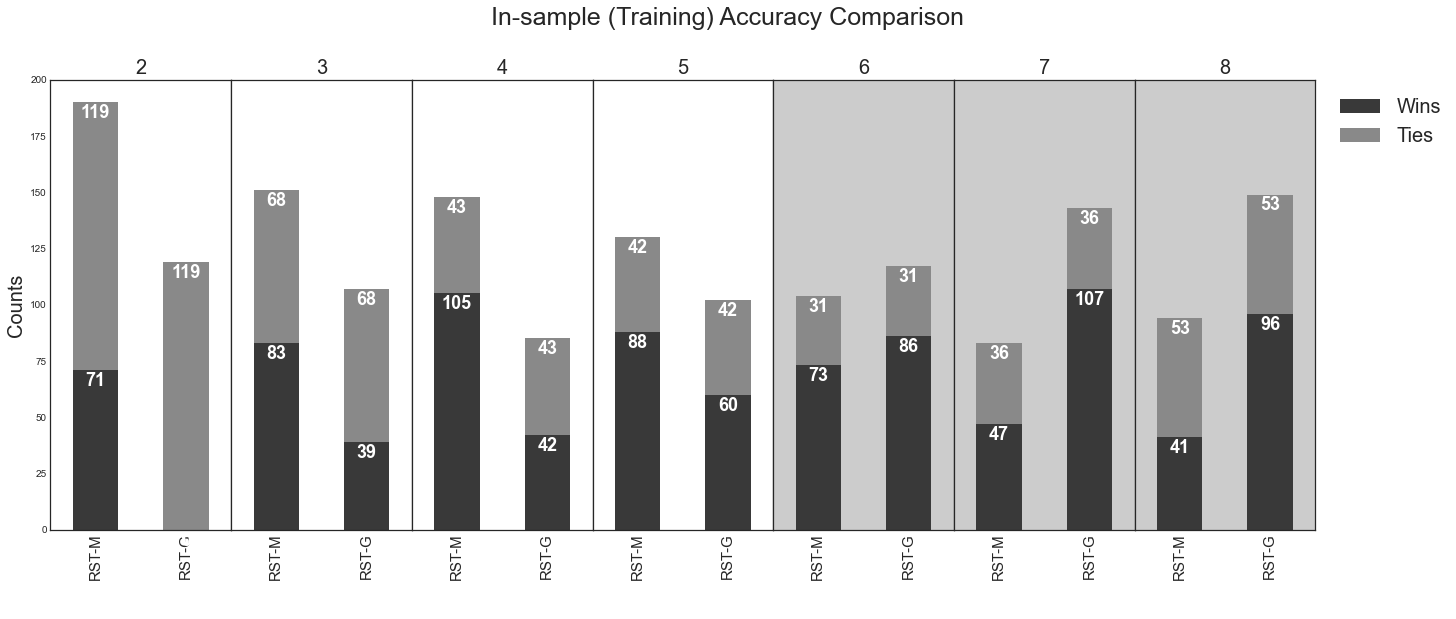

In [15]:
matplotlib.style.use("seaborn-white")

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20,8))
if key_metric == "Training Accuracy":
    mtr = "In-sample (Training) Accuracy Comparison"
else:
    mtr = "Out-of-sample (Test) Accuracy Comparison"
plt.suptitle(mtr, size=25, y=1.05)
ax_position = 0
y_offset = -7 # decrease value if you want to decrease the position of data labels
for metric in df_.index.get_level_values('depth').unique():
    idx = pd.IndexSlice
    subset = df_.loc[idx[[metric], :],
                    ['Wins', 'Ties']]   
    subset = subset.groupby(
        subset.index.get_level_values('model')).sum()
    if model_list == ['CART-G', 'HybridRST', 'BendersOCT']:
        custom_dict = {'BendersOCT':2, 'HybridRST':1, 'CART-G':0}
        sort_by_custom_dict = sort_pd(key=custom_dict.get)
    elif model_list == ["RST-M", "RST-G"]:
        custom_dict = {'RST-G':1, 'RST-M':0}
        sort_by_custom_dict = sort_pd(key=custom_dict.get)

        subset = subset.iloc[sort_by_custom_dict(subset.index.get_level_values('model'))]
    ax = subset.plot(kind="bar", stacked=True, cmap=cmap1,
                     ax=axes[ax_position], width=0.5)

    ax.set_title(metric, fontsize=20, alpha=1.0)
    ax.set_xlabel(metric, fontsize=30, alpha=0.0)
    ax.set_ylabel("Counts", fontsize=20)
    ax.set_xticklabels(labels=model_list, rotation=90,
                       minor=False, fontsize=15)
    ax.set_ylim(0, 200)
    #ax.set_yticks("")
    handles, labels = ax.get_legend_handles_labels()
    if ax_position > 0:
        ax.set_yticklabels("")
        ax.set_ylabel("")
        ax.legend().set_visible(False)
    ax_position += 1
    if metric > 5 and model_list == ["RST-M", "RST-G"]:
        ax.set_facecolor("#CCCCCC")
    for bar in ax.patches:
        ax.text(
          # Put the text in the middle of each bar. get_x returns the start
          # so we add half the width to get to the middle.
          bar.get_x() + bar.get_width() / 2,
          # Vertically, add the height of the bar to the start of the bar,
          # along with the offset.
          bar.get_height() + bar.get_y() + y_offset,
          # This is actual value we'll show.
          round(bar.get_height()),
          # Center the labels and style them a bit.
          ha='center',
          color='w',
          weight='bold',
          size=18
      )

# sns.set_theme(style="ticks", palette="pastel")


ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=20)
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0) # increase w_pad if you'd like to separate charts
axes[1].set_yticklabels("")
axes[1].set_ylabel("")
axes[0].legend().set_visible(False)